In [51]:
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from scipy.optimize import least_squares
from scipy.stats import norm
from os import listdir
from os.path import isfile, join

In [52]:
onlyfiles = [f for f in listdir(r'C:\Users\Joshua\Documents\GitHub\SHP\Muon Measurement Data')]

In [53]:
raw_data = np.loadtxt(f'C:/Users/Joshua/Documents/GitHub/SHP/Muon Measurement Data/{onlyfiles[-1]}')
raw_data[:,1] = raw_data[:,1] - raw_data[0,1]
raw_data[:,1]

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 6.07808e+05,
       6.07809e+05, 6.07810e+05])

In [54]:
time_bet_decay = []
#time_bet_timeout

In [55]:
for i in raw_data:
    if i[0]<4e04:
        time_bet_decay.append(i[0])

In [56]:
num_bins = 40

In [57]:
length = len(time_bet_decay)
bin_length = len(time_bet_decay)//num_bins
count_array = []
bins_array = []
count=0
for i in range(num_bins):
    for j in time_bet_decay:
        if j < i*bin_length and j > (i-1)*bin_length and i>1:
            count+=1
    count_array.append(count)
    count=0
    bins_array.append(i*bin_length)
count_array = count_array[1:]

In [58]:
max_count = np.max(count_array)
count_frac = []
bin_frac = []
iterations = int(math.log2(num_bins))
bin_frac_val = 0
for i in range(0,iterations):
    binary = 2**i
    count_frac.append(max_count/binary)
    for j in range(len(count_array)):
        if count_array[j] < count_frac[i] and count_array[j-1] > count_frac[i]:
            bin_frac_val = bins_array[j+1]
    bin_frac.append(bin_frac_val)

diff = [bin_frac[i + 1] - bin_frac[i] for i in range(len(bin_frac) - 1)]
print(diff)
half_life = np.average(diff[1:])
print('Half-life: ', np.average(diff[1:]))

[1976, 1729, 1235, 1729]
Half-life:  1564.3333333333333


In [174]:
from numpy.random import default_rng
rng = default_rng()
def gen_data(t, a, b, c, noise=0., n_outliers=0, seed=None):
    rng = default_rng(seed)
    y = a*np.exp(-(x/b))+c
    error = noise * rng.standard_normal(t.size)
    outliers = rng.integers(0, t.size, n_outliers)
    error[outliers] *= 10
    return y + error

a = 1200
b = 1500
c = 0.5

background = 30
delay = 80

t_min = min(bins_array)+delay
t_max = max(bins_array)
n_points = num_bins-1

t_train = np.linspace(t_min, t_max, n_points)
y_train = np.subtract(count_array, background)

In [175]:
def fun(x, t, y):
    return x[0]*np.exp(-(t/x[1]))+x[2] - y

x0 = np.array([1300, 1550, 0])

In [176]:
res_lsq = least_squares(fun, x0, args=(t_train, y_train))

In [177]:
res_soft_l1 = least_squares(fun, x0, loss='soft_l1', f_scale=0.1,
                            args=(t_train, y_train))
res_log = least_squares(fun, x0, loss='cauchy', f_scale=0.1,
                        args=(t_train, y_train))

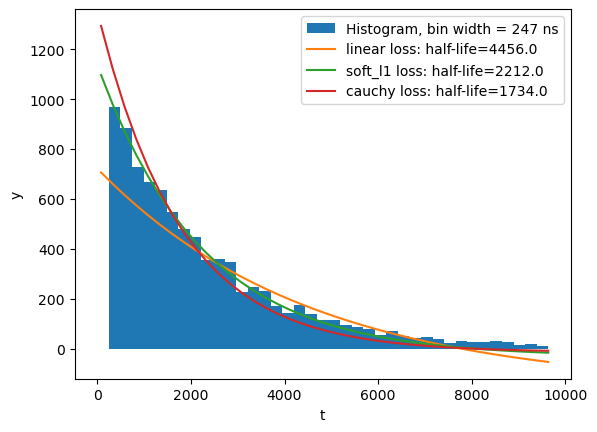

In [178]:
t_test = np.linspace(t_min, t_max, n_points)
y_true = count_array
y_lsq = gen_data(t_test, * res_lsq.x)
y_soft_l1 = gen_data(t_test, * res_soft_l1.x)
y_log = gen_data(t_test, * res_log.x)

import matplotlib.pyplot as plt
n, bins, patches = plt.hist(bins_array[:-1], bins_array, weights=count_array, label=f'Histogram, bin width = {bin_length} ns')
plt.plot(t_test, y_lsq, label=f'linear loss: half-life={np.round(res_lsq.x[1])}')
plt.plot(t_test, y_soft_l1, label=f'soft_l1 loss: half-life={np.round(res_soft_l1.x[1])}')
plt.plot(t_test, y_log, label=f'cauchy loss: half-life={np.round(res_log.x[1])}')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [92]:
x = bins_array[:-1]
y = count_array

In [93]:
def fun(p, x, y):
    return p[0]*np.exp(-(x/p[1]))+p[2]
p0 = np.array([900, 1550, 0.5])

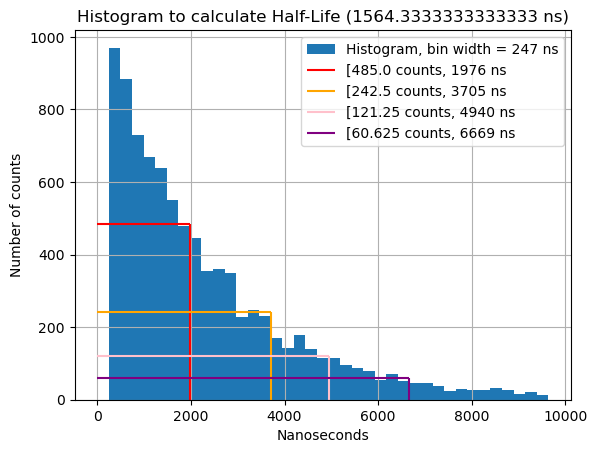

In [95]:
n, bins, patches = plt.hist(bins_array[:-1], bins_array, weights=count_array, label=f'Histogram, bin width = {bin_length} ns')

colours = ['','red', 'orange', 'pink', 'purple', 'black', 'brown', 'gray', 'green']
for i in range(1,iterations):
    plt.vlines(ymin=0, x=bin_frac[i], color=colours[i], ymax=count_frac[i], label = f'[{count_frac[i]} counts, {bin_frac[i]} ns')
    plt.hlines(xmin=0, xmax=bin_frac[i], y=count_frac[i], color=colours[i])
plt.ylabel('Number of counts')
plt.xlabel('Nanoseconds')
plt.grid()
plt.title(f'Histogram to calculate Half-Life ({half_life} ns)')
plt.legend()